In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

# Add the parent directory to sys.path so Python can find the files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
from EKI.eki import *
from EKI.stopping_rules import *
from EKI.uq import *
from ForwardModels.models import *
from Utils.tools import *
from Mala.mala import *

In [3]:
D = 10
L = 2 * jnp.pi
h = (2 * jnp.pi) / D
ones_mat = jnp.ones((D + 1, D + 1))
delta_h = compute_second_order_diff(D, h)
init_mean = jnp.zeros(D + 1)
delta = 1e2
gamma = 1 / (2 * np.sqrt(h))

sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

In [4]:
rng_key = random.PRNGKey(0)

ensemble = random.normal(rng_key, shape=(D + 1, 100))

ensemble = init_mean[:, jnp.newaxis] + jnp.dot(sqrt_covar, ensemble)

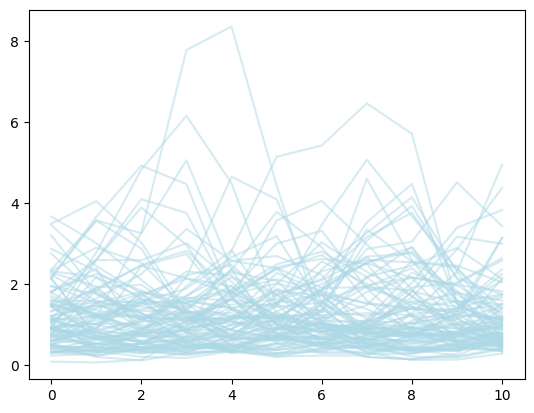

In [5]:
plt.plot(jnp.exp(ensemble), color="lightblue", alpha=0.5)
plt.show()

In [6]:
def run(
    f0,
    g_array,
    plot,
    h,
    dim_parameters,
    dim_observations,
    num_particles,
    noise_level=1e-6,
):
    """Run a simple EKI example."""
    # Set random seed for reproducibility
    key = random.PRNGKey(42)

    forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)

    y_true = forward_model.evaluate_single(f0)  # (dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise
    # plt.plot(i_array, f0)
    # plt.plot(i_array, y_true)
    # plt.show()
    ones_mat = jnp.ones((dim_parameters + 1, dim_parameters + 1))
    delta_h = compute_second_order_diff(dim_parameters, h)
    init_mean = jnp.zeros(dim_parameters + 1)
    delta = 1e2
    gamma = 1 / (2 * jnp.sqrt(h))

    sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

    prior_cov = sqrt_covar
    # Initialize EKI solver
    eki = EKI(
        forward_model=forward_model,
        observations=observations,
        dim_parameters=dim_parameters,
        num_particles=num_particles,
        init_covariance=prior_cov,
        init_mean=init_mean,
        noise_level=noise_level,
        time_interval=(1, 200, 200),  # (start, end, max_steps)
        rng_key=key,
    )
    if noise_level > 1e-3:
        kappa = 0.1
    else:
        kappa = 0.5
    # Create stopping rule: Discrepancy principle
    stopping_rule = DiscrepancyPrinciple(
        effective_dim=dim_observations,
        tolerance=noise_level,
        kappa=kappa,
        max_iterations=100,
    )

    # Run the algorithm with early stopping
    results = eki.fit(stopping_rule=stopping_rule)

    # Print results
    print(f"C:{kappa}")
    print(f"\nAlgorithm converged: {results['converged']}")
    print(f"Stopping time: {results['stopping_time']}")
    print(f"Final residual: {results['final_residual']:.6f}")

    return results

In [7]:
# global parameters
dim_parameters = 100
dim_observations = 100
plot = False
num_particles = 50

noise_levels = [1e-2, 1e-4, 1e-6, 1e-8]
print(noise_levels)

[0.01, 0.0001, 1e-06, 1e-08]


In [8]:
L = 2 * jnp.pi
h = (2 * jnp.pi) / dim_parameters
x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
f0 = jnp.exp(0.5 * jnp.sin(x_array))
g_array = (
    jnp.exp(-((x_array - L / 2) ** 2) / 10)
    - jnp.exp(-((x_array - L / 2) ** 2) / 10).mean()
)

In [9]:
results_list = []
for noise_level in noise_levels:
    results = run(
        f0,
        g_array,
        plot,
        h,
        dim_parameters,
        dim_observations,
        num_particles,
        noise_level,
    )
    results_list.append(results)

nonlinear
converged
C:0.1

Algorithm converged: True
Stopping time: 4
Final residual: 0.092744
nonlinear
converged
C:0.5

Algorithm converged: True
Stopping time: 2
Final residual: 0.040081
nonlinear
converged
C:0.5

Algorithm converged: True
Stopping time: 6
Final residual: 0.000463
nonlinear
converged
C:0.5

Algorithm converged: True
Stopping time: 7
Final residual: 0.000305


In [10]:
def rescale_ensemble(tau, ensemble):
    ensemble_mean = jnp.mean(
        ensemble, axis=1, keepdims=True
    )  # shape (dim_parameters, 1)
    ensemble_centered = ensemble - ensemble_mean

    # Rescale the variance:
    ensemble_scaled = ensemble_mean + jnp.sqrt(tau) * ensemble_centered

    return ensemble_scaled

In [11]:
time_interval = np.arange(1, 200, 1)
taus = []
rescaled_ensemble_list = []
for results in results_list:
    stopping_index = results["stopping_time"]
    stopping_time = time_interval[stopping_index]
    taus.append(stopping_time)
    print("stopping time", stopping_time)

    ensemble = results["ensemble_history"][-1]
    rescaled_ensemble = rescale_ensemble(stopping_time, ensemble)
    rescaled_ensemble_list.append(rescaled_ensemble)

stopping time 5
stopping time 3
stopping time 7
stopping time 8


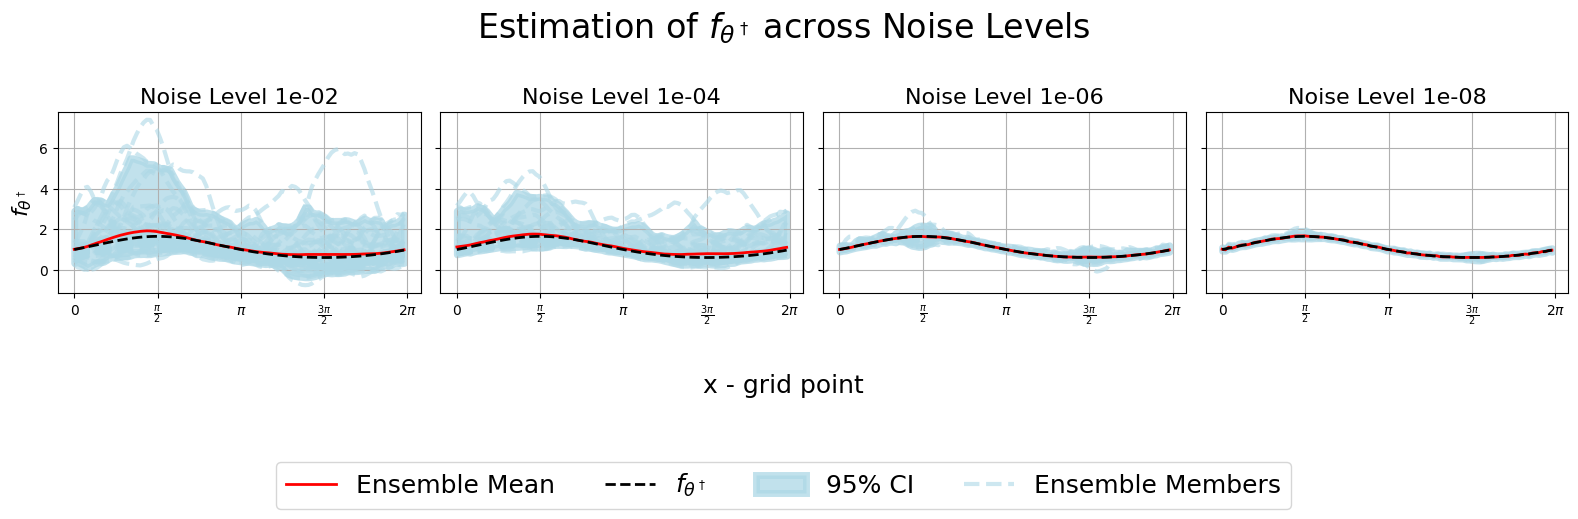

In [12]:
import matplotlib.pyplot as plt

x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.025, 0.975])

num_levels = len(results_list)  # number of noise levels

fig, axes = plt.subplots(
    1,  # single row
    num_levels,
    figsize=(4 * num_levels, 4),
    sharex=True,
    sharey=True,
)

# Handle the case where there's only one noise level
if num_levels == 1:
    axes = [axes]

# Loop over noise levels (columns)
for col_idx, results in enumerate(rescaled_ensemble_list):
    ax = axes[col_idx]

    hat_coefs_f0_ensemble = rescaled_ensemble_list[col_idx]

    # Plot individual ensemble members
    ensemble_members_handle = ax.plot(
        x_array,
        hat_coefs_f0_ensemble,
        color="lightblue",
        linestyle="dashed",
        alpha=0.6,
        linewidth=3,
    )

    # Ensemble mean
    (ensemble_mean_handle,) = ax.plot(
        x_array,
        jnp.mean(hat_coefs_f0_ensemble, axis=1),
        color="red",
        linewidth=2,
        label="ensemble mean",
    )
    mean = jnp.mean(hat_coefs_f0_ensemble, axis=1)
    diff = jnp.linalg.norm(f0 - mean)
    # print(diff)
    # True f0
    (f0_handle,) = ax.plot(
        x_array,
        f0,
        color="black",
        label=r"$\theta^\dagger$",
        linestyle="dashed",
        linewidth=2,
    )

    # Quantiles
    quantiles = jnp.quantile(hat_coefs_f0_ensemble, q, axis=1)
    fill_handle = ax.fill_between(
        x_array,
        quantiles[0],
        quantiles[1],
        color="lightblue",
        alpha=0.75,
        label="95% CI",
        linewidth=5,
    )

    # Set title for each subplot
    ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
    ax.grid(True)

# Set ylabel for the single row
axes[0].set_ylabel(r"$f_{\theta^\dagger}$", fontsize=16)

fig.supxlabel("x - grid point", fontsize=18)

# Common legend
handles = [ensemble_mean_handle, f0_handle, fill_handle, ensemble_members_handle[0]]
labels = ["Ensemble Mean", r"$f_{\theta^\dagger}$", "95% CI", "Ensemble Members"]
fig.legend(
    handles, labels, loc="lower center", ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.3)
)

# Main title
fig.suptitle(r"Estimation of $f_{\theta^\dagger}$ across Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

stopping time 5
stopping time 3
stopping time 7
stopping time 8


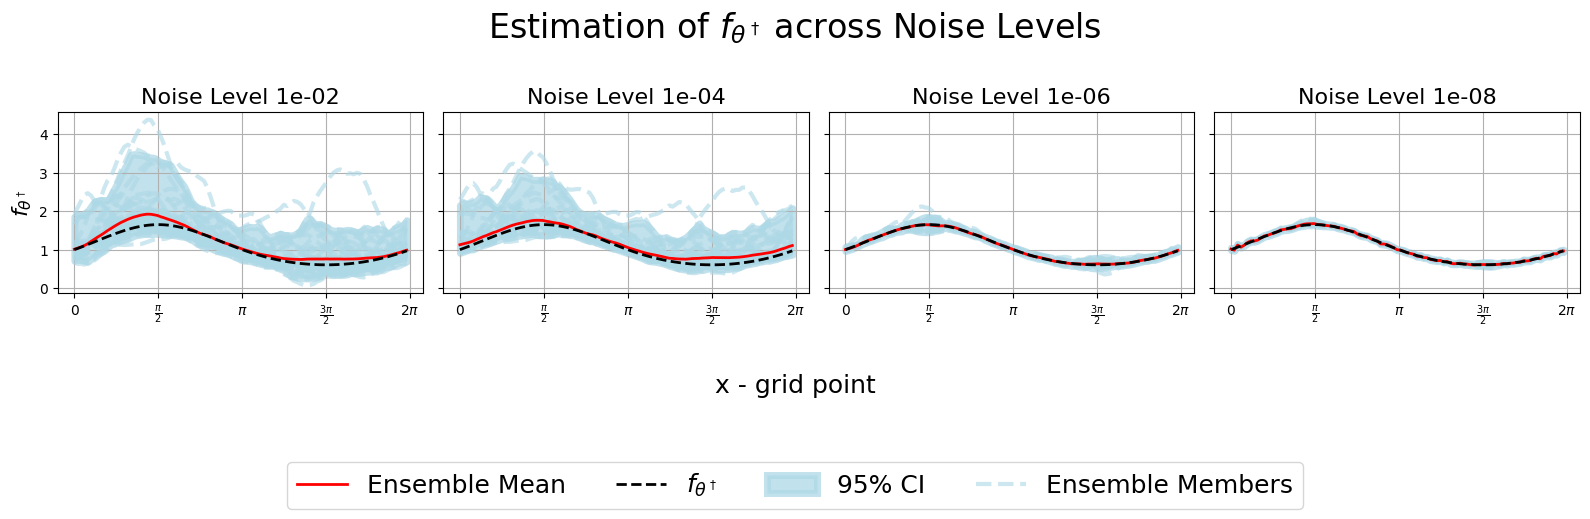

In [13]:
import matplotlib.pyplot as plt

x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.025, 0.975])

num_levels = len(results_list)  # number of noise levels

fig, axes = plt.subplots(
    1,  # single row
    num_levels,
    figsize=(4 * num_levels, 4),
    sharex=True,
    sharey=True,
)

# Handle the case where there's only one noise level
if num_levels == 1:
    axes = [axes]

# Loop over noise levels (columns)
for col_idx, results in enumerate(results_list):
    ax = axes[col_idx]
    print("stopping time", len(results["ensemble_history"]))
    hat_coefs_f0_ensemble = results["ensemble_history"][-1]

    # Plot individual ensemble members
    ensemble_members_handle = ax.plot(
        x_array,
        hat_coefs_f0_ensemble,
        color="lightblue",
        linestyle="dashed",
        alpha=0.6,
        linewidth=3,
    )

    # Ensemble mean
    (ensemble_mean_handle,) = ax.plot(
        x_array,
        jnp.mean(hat_coefs_f0_ensemble, axis=1),
        color="red",
        linewidth=2,
        label="ensemble mean",
    )
    mean = jnp.mean(hat_coefs_f0_ensemble, axis=1)
    diff = jnp.linalg.norm(f0 - mean)
    # print(diff)
    # True f0
    (f0_handle,) = ax.plot(
        x_array,
        f0,
        color="black",
        label=r"$\theta^\dagger$",
        linestyle="dashed",
        linewidth=2,
    )

    # Quantiles
    quantiles = jnp.quantile(hat_coefs_f0_ensemble, q, axis=1)
    fill_handle = ax.fill_between(
        x_array,
        quantiles[0],
        quantiles[1],
        color="lightblue",
        alpha=0.75,
        label="95% CI",
        linewidth=5,
    )

    # Set title for each subplot
    ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
    ax.grid(True)

# Set ylabel for the single row
axes[0].set_ylabel(r"$f_{\theta^\dagger}$", fontsize=16)

fig.supxlabel("x - grid point", fontsize=18)

# Common legend
handles = [ensemble_mean_handle, f0_handle, fill_handle, ensemble_members_handle[0]]
labels = ["Ensemble Mean", r"$f_{\theta^\dagger}$", "95% CI", "Ensemble Members"]
fig.legend(
    handles, labels, loc="lower center", ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.3)
)

# Main title
fig.suptitle(r"Estimation of $f_{\theta^\dagger}$ across Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [14]:
hat_coefs_f0_ensemble.shape

(101, 50)

In [15]:
time_interval = np.arange(1, 200, 1)
taus = []
for results in results_list:
    stopping_index = results["stopping_time"]
    stopping_time = time_interval[stopping_index]
    print("stopping time", stopping_time)
    taus.append(stopping_time)

stopping time 5
stopping time 3
stopping time 7
stopping time 8


In [16]:
import numpyro

import numpyro.distributions as dist

In [17]:
forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)


def posterior(dim_parameters, sigma, prior_cov, y=None):
    theta = numpyro.sample(
        "theta",
        dist.MultivariateNormal(
            loc=jnp.zeros(dim_parameters + 1), covariance_matrix=prior_cov
        ),
    )

    f_theta = jnp.exp(theta)

    uf = forward_model.evaluate_single(f_theta)
    noise_matrix = jnp.eye(dim_parameters + 1) * sigma
    numpyro.sample("obs", dist.MultivariateNormal(uf, noise_matrix), obs=y)

In [18]:
from jax import random

from numpyro.infer import MCMC, NUTS

In [19]:
# key = random.PRNGKey(42)
#
# forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)
#
# y_true = forward_model.evaluate_single(f0)  # (dim_parms, )
#
#  # Add noise to observations
# key, subkey = random.split(key)
# noise = noise_level * random.normal(subkey, y_true.shape)
# observations = y_true + noise
#
# ones_mat = jnp.ones((dim_parameters + 1, dim_parameters + 1))
# delta_h = compute_second_order_diff(dim_parameters, h)
# init_mean = jnp.zeros(dim_parameters + 1)
# delta = 1e2
# gamma = 1 / (2 * jnp.sqrt(h))
#
# sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)
#
#
#
# nuts_kernel = NUTS(posterior)
#
# mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000 , num_chains=10)
#
# rng_key = random.PRNGKey(0)
#
# mcmc.run(rng_key, dim_parameters, 0.001, sqrt_covar, y=observations)

In [20]:
for i, noise_level in enumerate(noise_levels):
    print(taus[i])

5
3
7
8


In [21]:
def run_mala(f0, g_array, plot, h, dim_parameters, dim_observations, noise_level, tau):
    key = random.PRNGKey(42)

    forward_model = Schroedinger(dim_parameters, dim_observations, f0, g_array, plot)

    y_true = forward_model.evaluate_single(f0)  # (dim_parms, )

    # Add noise to observations
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, y_true.shape)
    observations = y_true + noise

    ones_mat = jnp.ones((dim_parameters + 1, dim_parameters + 1))
    delta_h = compute_second_order_diff(dim_parameters, h)

    delta = 1e2
    gamma = 1 / (2 * jnp.sqrt(h))

    sqrt_covar = gamma * jnp.linalg.inv((delta * ones_mat / (D + 1)) - delta_h)

    prior_cov = tau * (sqrt_covar @ sqrt_covar.T)

    nuts_kernel = NUTS(posterior)

    mcmc = MCMC(
        nuts_kernel,
        num_warmup=500,
        num_samples=200,
        num_chains=1,
    )

    rng_key = random.PRNGKey(0)

    mcmc.run(rng_key, dim_parameters, noise_level, prior_cov, y=observations)
    return mcmc

In [22]:
numpyro.set_host_device_count(4)
jax.local_device_count()

1

In [23]:
samples_mala_list = []
for i, noise_level in enumerate(noise_levels):
    print("noise level", noise_level)
    print(taus[i])
    tau = taus[i]
    samples = run_mala(
        f0, g_array, plot, h, dim_parameters, dim_observations, noise_level, tau
    )
    samples_mala_list.append(samples)

noise level 0.01
5


sample: 100%|██████████| 700/700 [09:46<00:00,  1.19it/s, 511 steps of size 1.04e-02. acc. prob=0.88] 


noise level 0.0001
3


sample: 100%|██████████| 700/700 [04:35<00:00,  2.54it/s, 127 steps of size 2.29e-02. acc. prob=0.91] 


noise level 1e-06
7


sample: 100%|██████████| 700/700 [01:29<00:00,  7.86it/s, 127 steps of size 7.08e-02. acc. prob=0.89] 


noise level 1e-08
8


sample: 100%|██████████| 700/700 [12:18<00:00,  1.06s/it, 1023 steps of size 1.92e-07. acc. prob=0.93]


In [24]:
samples_mala_list[0].print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]     -0.03      0.27     -0.02     -0.46      0.43    159.27      1.00
  theta[1]     -0.00      0.27      0.01     -0.52      0.35    160.93      1.00
  theta[2]      0.03      0.28      0.05     -0.41      0.47    120.82      1.00
  theta[3]      0.06      0.28      0.10     -0.34      0.54     88.35      1.00
  theta[4]      0.09      0.29      0.12     -0.40      0.53     73.42      1.00
  theta[5]      0.13      0.30      0.13     -0.29      0.66     65.48      1.00
  theta[6]      0.16      0.31      0.14     -0.28      0.68     58.88      1.00
  theta[7]      0.20      0.31      0.16     -0.27      0.76     56.53      1.00
  theta[8]      0.23      0.32      0.20     -0.32      0.75     55.00      1.00
  theta[9]      0.26      0.33      0.23     -0.34      0.77     51.57      1.00
 theta[10]      0.29      0.35      0.25     -0.36      0.77     50.05      1.00
 theta[11]      0.32      0

In [25]:
samples_mala_list[0].get_samples()["theta"].shape

(200, 101)

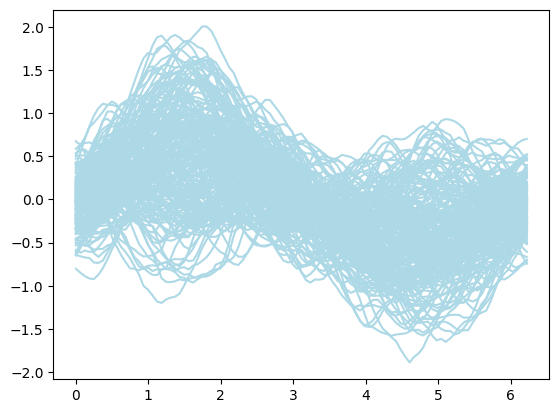

In [26]:
plt.plot(x_array, samples_mala_list[0].get_samples()["theta"].T, color="lightblue")
plt.show()

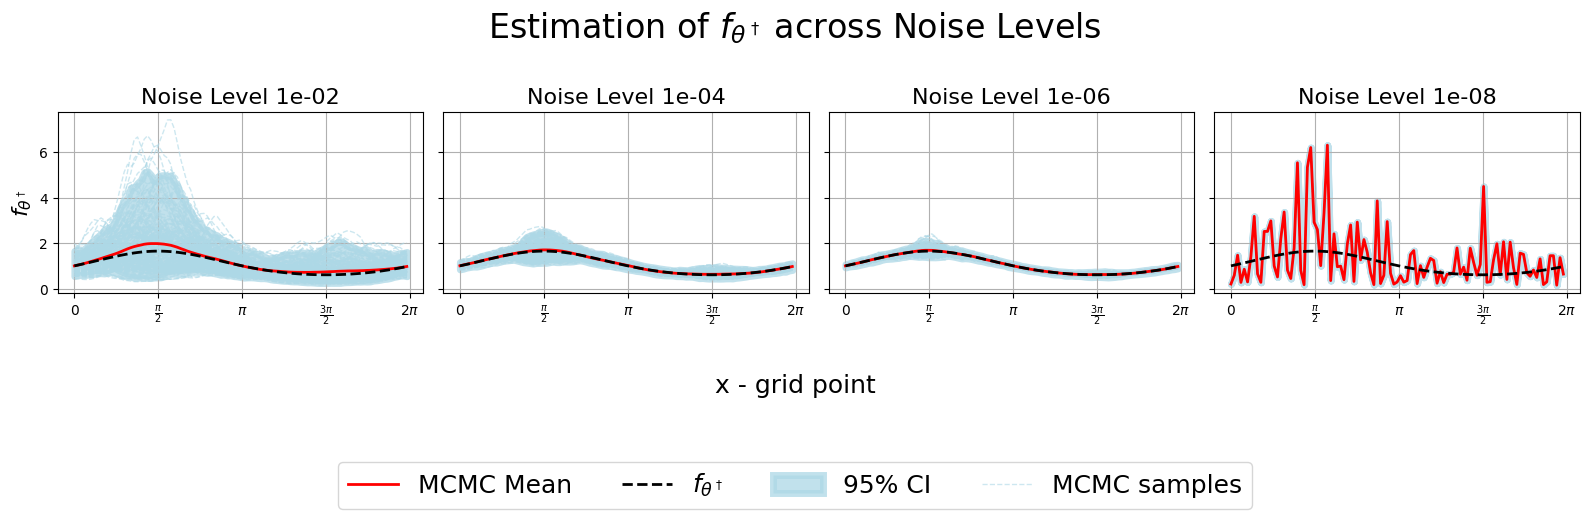

In [27]:
x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.025, 0.975])

num_levels = len(results_list)  # number of noise levels

fig, axes = plt.subplots(
    1,  # single row
    num_levels,
    figsize=(4 * num_levels, 4),
    sharex=True,
    sharey=True,
)

# Handle the case where there's only one noise level
if num_levels == 1:
    axes = [axes]

# Loop over noise levels (columns)
for col_idx, results in enumerate(samples_mala_list):
    ax = axes[col_idx]

    mcmc_samples = jnp.exp(results.get_samples()["theta"])

    # Plot individual ensemble members
    samples_handle = ax.plot(
        x_array,
        mcmc_samples.T,
        color="lightblue",
        linestyle="dashed",
        alpha=0.6,
        linewidth=1,
    )

    # Ensemble mean
    (sample_mean_handle,) = ax.plot(
        x_array,
        jnp.mean(mcmc_samples, axis=0),
        color="red",
        linewidth=2,
        label="ensemble mean",
    )

    (f0_handle,) = ax.plot(
        x_array,
        f0,
        color="black",
        label=r"$\theta^\dagger$",
        linestyle="dashed",
        linewidth=2,
    )

    # Quantiles
    quantiles = jnp.quantile(mcmc_samples, q, axis=0)
    fill_handle = ax.fill_between(
        x_array,
        quantiles[0],
        quantiles[1],
        color="lightblue",
        alpha=0.75,
        label="95% CI",
        linewidth=5,
    )

    # Set title for each subplot
    ax.set_title(f"Noise Level {noise_levels[col_idx]:.0e}", fontsize=16)
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
    ax.grid(True)

# Set ylabel for the single row
axes[0].set_ylabel(r"$f_{\theta^\dagger}$", fontsize=16)

fig.supxlabel("x - grid point", fontsize=18)

# Common legend
handles = [sample_mean_handle, f0_handle, fill_handle, samples_handle[0]]
labels = ["MCMC Mean", r"$f_{\theta^\dagger}$", "95% CI", "MCMC samples"]
fig.legend(
    handles, labels, loc="lower center", ncol=4, fontsize=18, bbox_to_anchor=(0.5, -0.3)
)

# Main title
fig.suptitle(r"Estimation of $f_{\theta^\dagger}$ across Noise Levels", fontsize=24)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

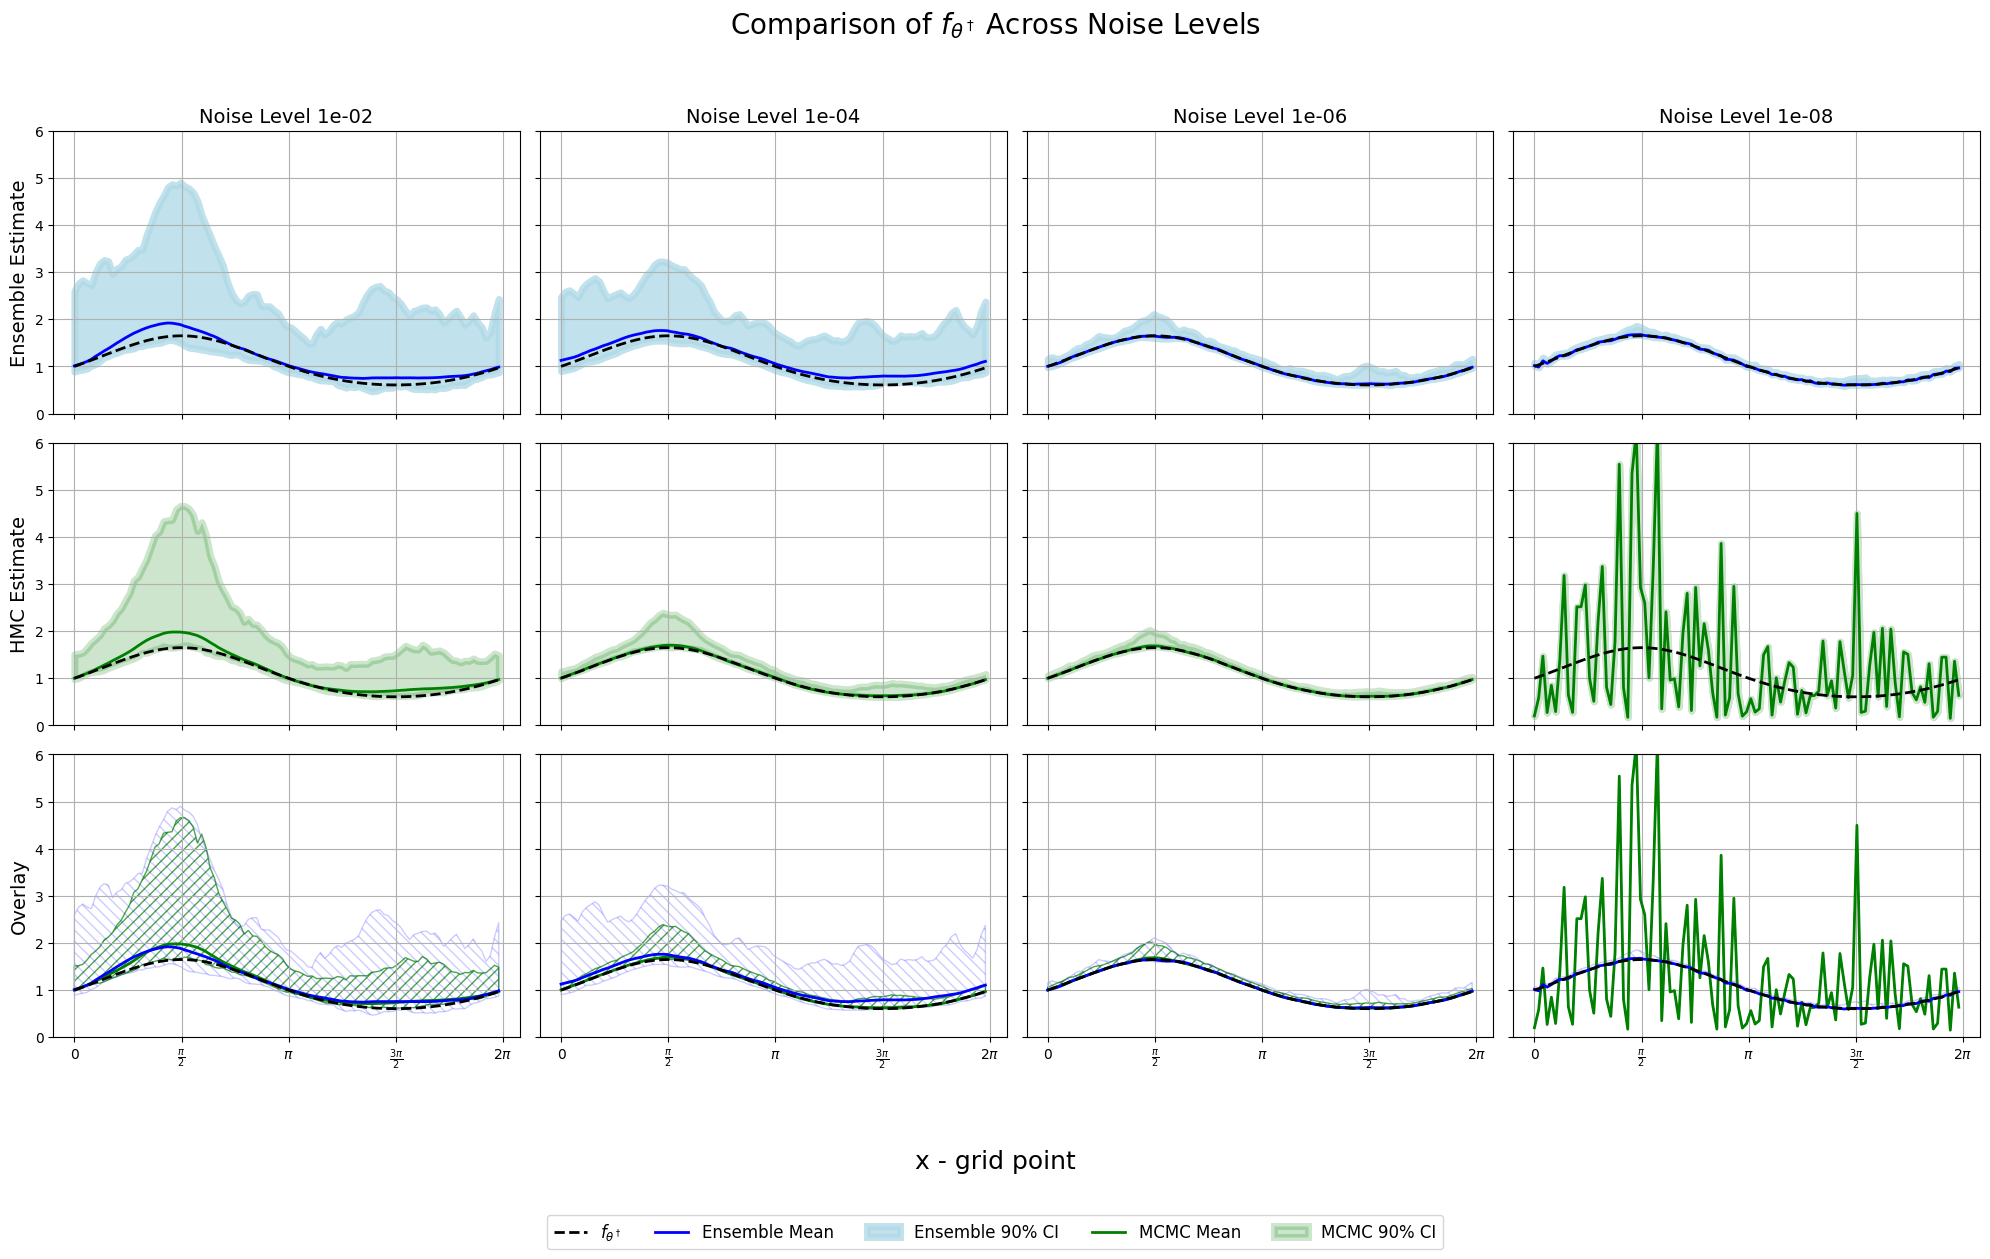

In [32]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np  # Needed for np.random.permutation

x_indices = jnp.arange(dim_parameters + 1)
x_array = (2 * jnp.pi * x_indices) / (dim_parameters + 1)
q = jnp.array([0.5, 0.95])
num_levels = len(results_list)

fig, axes = plt.subplots(
    3,  # 3 rows: Ensemble, MCMC, Overlay
    num_levels,
    figsize=(5 * num_levels, 12),
    sharex=True,
    sharey=True,
)

if num_levels == 1:
    axes = axes.reshape(3, 1)

for col_idx in range(num_levels):
    noise_level = noise_levels[col_idx]

    # ==== Row 0: Ensemble ====
    ax0 = axes[0, col_idx]
    ensemble_data = rescaled_ensemble_list[col_idx]

    ax0.plot(
        x_array,
        jnp.mean(ensemble_data, axis=1),
        color="blue",
        linewidth=2,
        label="Ensemble Mean" if col_idx == 0 else None,
    )

    ax0.plot(
        x_array,
        f0,
        color="black",
        linestyle="dashed",
        linewidth=2,
        label=r"$f_{\theta^\dagger}$" if col_idx == 0 else None,
    )

    quantiles_ens = jnp.quantile(ensemble_data, q, axis=1)
    ax0.fill_between(
        x_array,
        quantiles_ens[0],
        quantiles_ens[1],
        color="lightblue",
        alpha=0.75,
        linewidth=5,
        label="Ensemble 90% CI" if col_idx == 0 else None,
    )
    ax0.set_title(f"Noise Level {noise_level:.0e}", fontsize=14)
    ax0.grid(True)

    # ==== Row 1: MCMC ====
    ax1 = axes[1, col_idx]
    mcmc_samples = jnp.exp(samples_mala_list[col_idx].get_samples()["theta"])

    ax1.plot(
        x_array,
        jnp.mean(mcmc_samples, axis=0),
        color="green",
        linewidth=2,
        label="MCMC Mean" if col_idx == 0 else None,
    )

    ax1.plot(
        x_array,
        f0,
        color="black",
        linestyle="dashed",
        linewidth=2,
        label=r"$\f_{theta^\dagger}$" if col_idx == 0 else None,
    )

    quantiles_mcmc = jnp.quantile(mcmc_samples, q, axis=0)
    ax1.fill_between(
        x_array,
        quantiles_mcmc[0],
        quantiles_mcmc[1],
        color="green",
        alpha=0.2,
        linewidth=5,
        label="MCMC 90% CI" if col_idx == 0 else None,
    )
    ax1.grid(True)

    # ==== Row 2: Overlay ====
    ax2 = axes[2, col_idx]
    ax2.plot(x_array, jnp.mean(mcmc_samples, axis=0), color="green", linewidth=2)
    ax2.fill_between(
        x_array,
        quantiles_mcmc[0],
        quantiles_mcmc[1],
        color="none",
        hatch="///",
        edgecolor="green",
        alpha=0.7,
    )

    ax2.plot(x_array, jnp.mean(ensemble_data, axis=1), color="blue", linewidth=2)
    ax2.fill_between(
        x_array,
        quantiles_ens[0],
        quantiles_ens[1],
        color="none",
        hatch="\\\\\\",
        edgecolor="blue",
        alpha=0.2,
    )

    ax2.plot(x_array, f0, color="black", linestyle="dashed", linewidth=2)
    ax2.grid(True)

# === Y-axis Labels ===
axes[0, 0].set_ylabel("Ensemble Estimate", fontsize=14)
axes[1, 0].set_ylabel("HMC Estimate", fontsize=14)
axes[2, 0].set_ylabel("Overlay", fontsize=14)

# === X-axis Formatting ===
for ax in axes[2]:
    ax.set_xticks([0, jnp.pi / 2, jnp.pi, 3 * jnp.pi / 2, 2 * jnp.pi])
    ax.set_xticklabels(
        ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]
    )
    ax.set_ylim(0, 6)

fig.supxlabel("x - grid point", fontsize=18)

# === Legend (combined from Ensemble and MCMC rows) ===
handles_ens, labels_ens = axes[0, 0].get_legend_handles_labels()
handles_mcmc, labels_mcmc = axes[1, 0].get_legend_handles_labels()

# Combine and deduplicate
all_handles = handles_ens + handles_mcmc
all_labels = labels_ens + labels_mcmc
unique = dict()
for h, l in zip(all_handles, all_labels):
    if l not in unique:
        unique[l] = h

# Desired order: θ† first
desired_order = [
    r"$f_{\theta^\dagger}$",
    "Ensemble Mean",
    "Ensemble 90% CI",
    "MCMC Mean",
    "MCMC 90% CI",
]
handles = [unique[label] for label in desired_order if label in unique]
labels = [label for label in desired_order if label in unique]

# Draw legend
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=5,
    fontsize=12,
    bbox_to_anchor=(0.5, -0.06),
)

fig.suptitle(r"Comparison of $f_{\theta^\dagger}$ Across Noise Levels", fontsize=20)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()